In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from utils.preprocess import preprocess_leaf_image
from utils.feature_extraction import extract_leaf_features
from utils.search import LeafSearch
from utils.database import LeafDatabaseSQL

In [2]:
# Đường dẫn ảnh truy vấn
query_path = 'test_images/Leaf-type-in-db/83.jpg'

# --- Bước 1: Tiền xử lý và trích đặc trưng ảnh truy vấn ---
query_image = preprocess_leaf_image(query_path)
query_feature = extract_leaf_features(query_image)

In [3]:
# --- Bước 2: Tải database và truy xuất ---
db = LeafDatabaseSQL()
db.load_all_features(is_query=False)
search = LeafSearch(db)
results = search.search_with_feature_vector(query_feature, top_n=3)

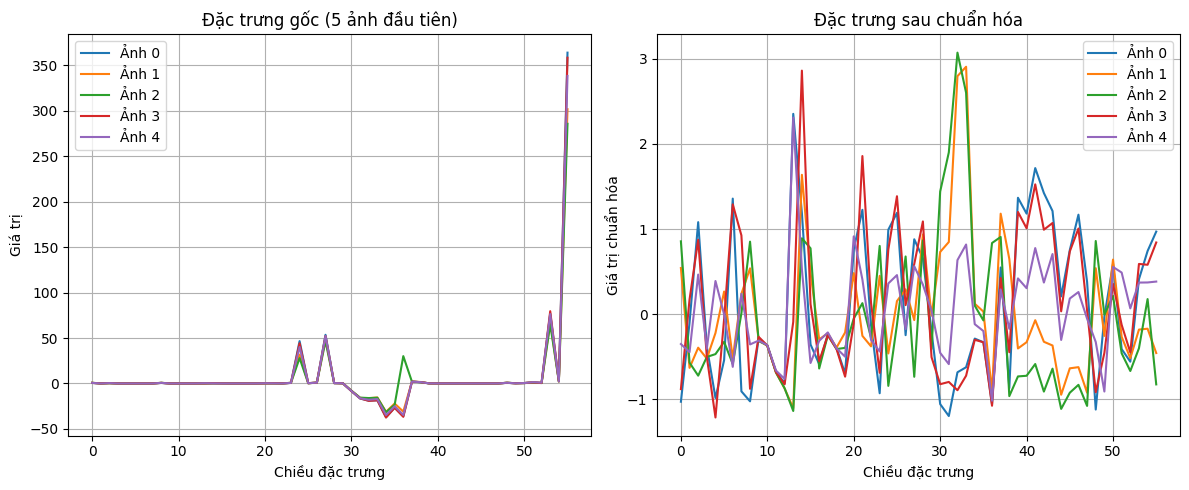

In [4]:
# --- Bước 3: Trực quan hóa quá trình chuẩn hóa bằng biểu đồ đường ---
raw_features = np.array(db.features)
normalized_features = search.norm_features

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for i in range(min(5, len(raw_features))):
    plt.plot(raw_features[i], label=f"Ảnh {i}")
plt.title("Đặc trưng gốc (5 ảnh đầu tiên)")
plt.xlabel("Chiều đặc trưng")
plt.ylabel("Giá trị")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for i in range(min(5, len(normalized_features))):
    plt.plot(normalized_features[i], label=f"Ảnh {i}")
plt.title("Đặc trưng sau chuẩn hóa")
plt.xlabel("Chiều đặc trưng")
plt.ylabel("Giá trị chuẩn hóa")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

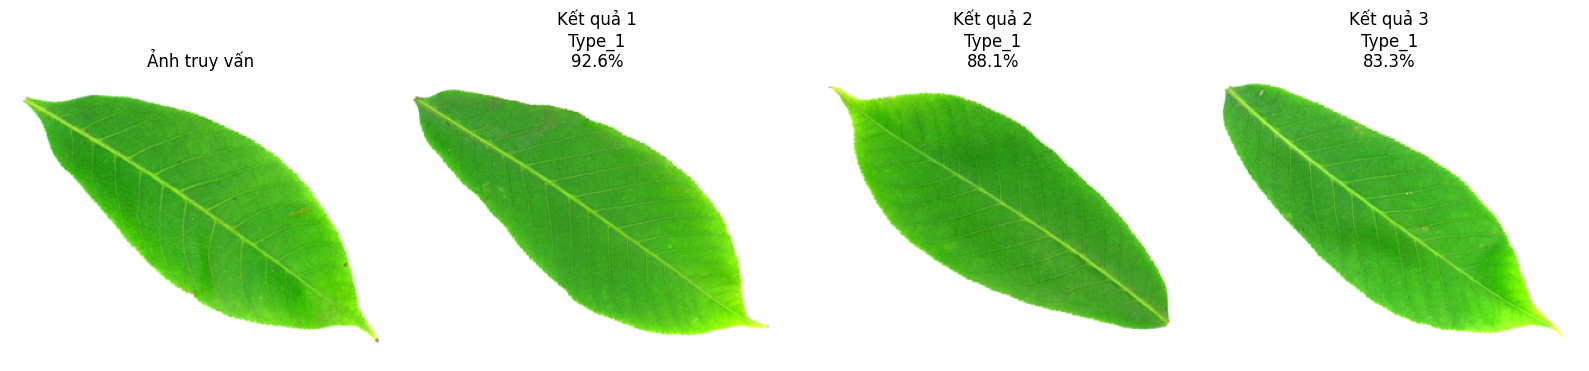

In [5]:
# --- Bước 4: Hiển thị truy vấn và các kết quả ---
plt.figure(figsize=(16, 4))
plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(cv2.imread(query_path), cv2.COLOR_BGR2RGB))
plt.title("Ảnh truy vấn")
plt.axis('off')

for i, res in enumerate(results):
    result_image = cv2.cvtColor(cv2.imread(res['path']), cv2.COLOR_BGR2RGB)
    plt.subplot(1, 4, i + 2)
    plt.imshow(result_image)
    plt.title(f"Kết quả {i+1}\n{res['label']}\n{res['similarity']*100:.1f}%")
    plt.axis('off')

plt.tight_layout()
plt.show()

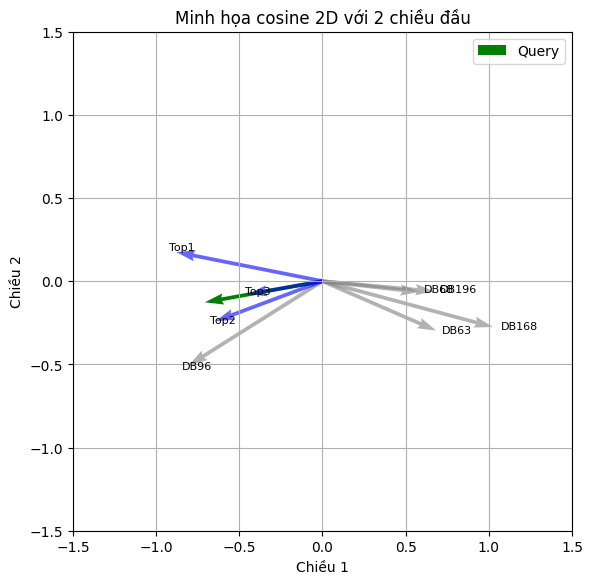

In [6]:
# --- Bước 5: Minh họa cosine trong không gian 2D toàn cục ---
query_vec = search.normalize_vector(query_feature)
angle_vectors = []
labels = []
colors = []

# Thêm 10 vector ngẫu nhiên từ dataset để so sánh
np.random.seed(41)
rand_indices = np.random.choice(len(db.features), size=5, replace=False)
for i in rand_indices:
    vec = search.norm_features[i]
    angle_vectors.append(vec[:2])
    labels.append(f"DB{i}")
    colors.append('gray')

# Thêm các vector kết quả gần nhất
for i, res in enumerate(results):
    if res['path'] in db.image_paths:
        idx = db.image_paths.index(res['path'])
        vec = search.norm_features[idx]
        angle_vectors.append(vec[:2])
        labels.append(f"Top{i+1}")
        colors.append('blue')

# Hiển thị minh họa cosine toàn cục
plt.figure(figsize=(6, 6))
origin = [0, 0]
plt.quiver(*origin, query_vec[0], query_vec[1], angles='xy', scale_units='xy', scale=1, color='green', label='Query')

for v, label, color in zip(angle_vectors, labels, colors):
    plt.quiver(*origin, v[0], v[1], angles='xy', scale_units='xy', scale=1, color=color, alpha=0.6)
    plt.text(v[0]*1.05, v[1]*1.05, label, fontsize=8)

plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.gca().set_aspect('equal')
plt.title("Minh họa cosine 2D với 2 chiều đầu")
plt.xlabel("Chiều 1")
plt.ylabel("Chiều 2")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()